In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

import sqlalchemy as sa
from ingester3.config import source_db_path

from views_dataviz import spl_extensions

In [2]:
engine = sa.create_engine(source_db_path)
gdf = gpd.GeoDataFrame.from_postgis(
    "SELECT id, geom FROM prod.priogrid WHERE in_africa=true", 
    engine, 
    geom_col='geom'
)
gdf_c = gpd.GeoDataFrame.from_postgis(
    "SELECT id, geom FROM prod.country WHERE in_africa=1", 
    engine, 
    geom_col='geom'
)
gdf = gdf.sort_values(by="id")
np.random.seed(1012)
gdf["preds"] = np.random.uniform(low=0, high=1, size=len(gdf))

In [3]:
n = 100
np.random.seed(1962)

mock = pd.DataFrame(
    {
        "y_true": np.concatenate(
            [
                np.random.choice([0, 1], size=(int(n / 4),), p=p) 
                for p in ([0.9, 0.1], [0.6, 0.4], [0.4, 0.6], [0.1, 0.9])
            ]
        ),
        "y_pred_a": np.arange(0, 0.9, 0.9 / n) + np.random.uniform(0, 0.1, n),
        "y_pred_b": np.random.uniform(0, 1, n),
        "id": np.random.choice(gdf.id.values, size=100)
    }
)

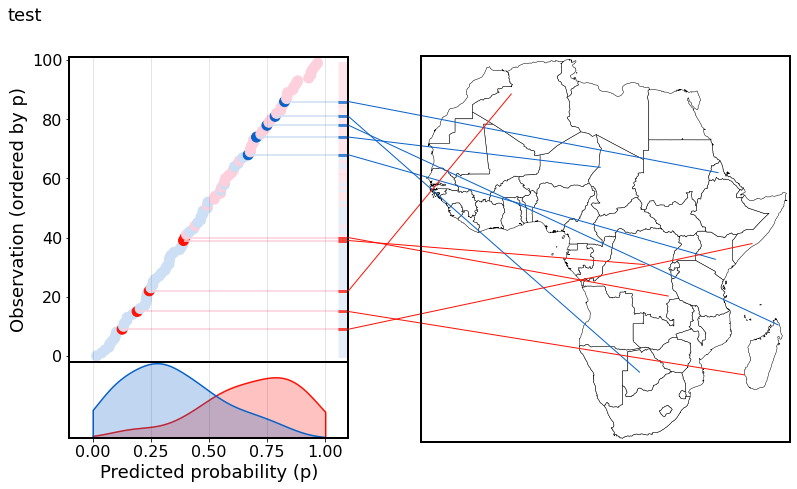

In [4]:
new = spl_extensions.ModelCriticismMap(
    df=mock, 
    y_true="y_true", 
    y_pred="y_pred_a", 
    lab="id",
    title="test",
    map_kwargs={"bbox": "africa"},
    mc_kwargs={"n_worst": 5},
).plot_map_layer(
    gdf=gdf_c,  
    color="white",
    edgecolor="black",
    linewidth=0.5,
    suppress_colorbar=True,
    suppress_textbox=True,
).connect(gdf)